In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import csv
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sb

### Data Process

In [64]:
f = open('data/2014data.txt')

rentals = []
for line in f:
    line = line.strip()
    if line[79] == '9':
        if line[411:413] == '30' or line[411:413] == '31' or line[411:413] == '90' or line[411:413] == '80':
            rentals.append(line)

rentals_file = []
for unit in rentals:
    new_unit = []
    new_unit.append(unit[1])
    if unit[411:413] == '30' or unit[411:413] == '31' or unit[411:413] == '90':
        if_control = 1
    elif unit[411:413] == '80':
        if_control = 0
    new_unit.append(if_control)
    new_unit.append(unit[2:8])
    new_unit.append(unit[8:13])
    new_unit.append(unit[13:19])
    new_unit.append(unit[19:25])
    new_unit.append(unit[25])
    new_unit.append(unit[139:141])
    new_unit.append(unit[152])
    new_unit.append(unit[154])
    new_unit.append(unit[157])
    new_unit.append(unit[190:195])
    new_unit.append(unit[206])
    new_unit.append(unit[208])
    new_unit.append(unit[214])
    new_unit.append(unit[215])
    new_unit.append(unit[227])
    new_unit.append(unit[238])
    new_unit.append(unit[239])
    new_unit.append(unit[241])
    new_unit.append(unit[243])
    new_unit.append(unit[418:420])
    new_unit.append(unit[141])
    new_unit.append(unit[195])
    new_unit.append(unit[427])
    new_unit.append(1)
    rentals_file.append(new_unit)

df = pd.DataFrame(rentals_file)

In [65]:
df.columns = ['Borough','Control','Condition of External Walls','Condition of Windows','Condition of Stairways','Condition of Floors',
                   'Condition of Building','Number of Units in Building','Complete Plumbing Facilities','Toilet Breakdowns','Kitchen Facilities Functioning','Monthly Contract Rent',
                   'Senior Citizen Rent Increase Exemption (SCRIE)', 'Public Assistance Shelter Allowance', 
                   'Another Federal Housing Subsidy Program', 'Another State or City Housing Subsidy Program',
                   'Heating Equipment Breakdown', 'Exterminator Service',
                   'Cracks or Holes in Interior Walls or Ceiling', 'Broken Plaster or Peeling Paint on Ceiling or Inside Walls', 'Water Leakage Inside Apartment',
                   'Year Built', 'Owner in Building', 'Length of Lease', 'Race', 'New Rent Law']
df.head()

,Borough,Control,Condition of External Walls,Condition of Windows,Condition of Stairways,Condition of Floors,Condition of Building,Number of Units in Building,Complete Plumbing Facilities,Toilet Breakdowns,...,Heating Equipment Breakdown,Exterminator Service,Cracks or Holes in Interior Walls or Ceiling,Broken Plaster or Peeling Paint on Ceiling or Inside Walls,Water Leakage Inside Apartment,Year Built,Owner in Building,Length of Lease,Race,New Rent Law
0,3,1,999919,99919,991999,999919,2,12,0,2,...,1,2,2,1,2,07,2,2,1,1
1,2,0,999919,99919,991999,999919,2,05,0,1,...,1,2,2,1,2,07,2,6,4,1
2,2,1,999919,99919,991999,999919,2,11,0,2,...,1,4,1,1,2,09,2,4,2,1
3,2,1,999919,99919,991999,999919,2,13,0,2,...,1,5,2,1,2,05,3,4,2,1
4,2,1,999919,99919,991999,991999,2,13,0,8,...,8,8,8,8,8,08,8,8,1,1


In [68]:
data = df.astype('int64')

In [73]:
data['Old'] = 0

In [74]:
data['Old'].loc[data['Year Built'] >= 7] = 1

In [76]:
data['Control'].value_counts()

1    4966
0    3825
Name: Control, dtype: int64

In [77]:
data['More_units'] = 0
data['Number of Units in Building'] = data['Number of Units in Building'].apply(int)
data['More_units'].loc[data['Number of Units in Building'] >= 12] = 1

In [79]:
data['Brooklyn'] = 0
data['Manhattan'] = 0
data['Staten Island'] = 0
data['Bronx'] = 0
data['Borough'] = data['Borough'].apply(int)

In [80]:
data['Brooklyn'].loc[data['Borough'] == 2] = 1
data['Manhattan'].loc[data['Borough'] == 3] = 1
data['Staten Island'].loc[data['Borough'] == 5] = 1
data['Bronx'].loc[data['Borough'] == 1] = 1

In [81]:
data[['Brooklyn','Manhattan', 'Staten Island', 'Bronx', 'Old', 'Control', 'More_units']].corr()

,Brooklyn,Manhattan,Staten Island,Bronx,Old,Control,More_units
Brooklyn,1.000000,-0.409277,-0.112270,-0.285561,0.145176,-0.044047,-0.161248
Manhattan,-0.409277,1.000000,-0.108463,-0.275877,0.009261,0.059493,0.224823
Staten Island,-0.112270,-0.108463,1.000000,-0.075677,-0.129545,-0.121203,-0.081919
Bronx,-0.285561,-0.275877,-0.075677,1.000000,0.051688,0.155544,0.047670
Old,0.145176,0.009261,-0.129545,0.051688,1.000000,0.168381,-0.297347
Control,-0.044047,0.059493,-0.121203,0.155544,0.168381,1.000000,0.212116
More_units,-0.161248,0.224823,-0.081919,0.047670,-0.297347,0.212116,1.000000


In [82]:
data['score'] = 0

In [83]:
data.shape

(8791, 33)

In [84]:
data['Condition of External Walls'] = data['Condition of External Walls'].apply(str)
data['Condition of Windows'] = data['Condition of Windows'].apply(str)
data['Condition of Stairways'] = data['Condition of Stairways'].apply(str)
data['Condition of Floors'] = data['Condition of Floors'].apply(str)

In [85]:
for index in range(len(data)):
    external_walls = data['Condition of External Walls'].iloc[index]
    windows = data['Condition of Windows'].iloc[index]
    stairways = data['Condition of Stairways'].iloc[index]
    floors = data['Condition of Floors'].iloc[index]
    toilet = data['Toilet Breakdowns'].iloc[index]
    kitchen = data['Kitchen Facilities Functioning'].iloc[index]
    heating = data['Heating Equipment Breakdown'].iloc[index]
    crack = data['Cracks or Holes in Interior Walls or Ceiling'].iloc[index]
    plaster = data['Broken Plaster or Peeling Paint on Ceiling or Inside Walls'].iloc[index]
    water = data['Water Leakage Inside Apartment'].iloc[index]
    if external_walls[0] == "1":
        data['score'].iloc[index] -= 1
    if external_walls[1] == "1":
        data['score'].iloc[index] -= 1
    if external_walls[2] == "1":
        data['score'].iloc[index] -= 1
    if external_walls[3] == "1":
        data['score'].iloc[index] -= 1
    if external_walls[4] == "1":
        data['score'].iloc[index] += 1
    if windows[0] == "1":
        data['score'].iloc[index] -= 1
    if windows[1] == "1":
        data['score'].iloc[index] -= 1
    if windows[2] == "1":
        data['score'].iloc[index] -= 1
    if windows[3] == "1":
        data['score'].iloc[index] += 1
    if stairways[0] == "1":
        data['score'].iloc[index] -= 1
    if stairways[1] == "1":
        data['score'].iloc[index] -= 1
    if stairways[2] == "1":
        data['score'].iloc[index] += 1
    if floors[0] == "1":
        data['score'].iloc[index] -= 1
    if floors[1] == "1":
        data['score'].iloc[index] -= 1
    if floors[2] == "1":
        data['score'].iloc[index] -= 1
    if floors[3] == "1":
        data['score'].iloc[index] -= 1
    if floors[4] == "1":
        data['score'].iloc[index] += 1
    if toilet == 1:
        data['score'].iloc[index] -= 1
    if toilet == 2:
        data['score'].iloc[index] += 1
    if toilet == 3:
        data['score'].iloc[index] -= 1
    if toilet == 9:
        data['score'].iloc[index] -= 1
    if kitchen == 1:
        data['score'].iloc[index] += 1
    if kitchen == 2:
        data['score'].iloc[index] -= 1
    if kitchen == 9:
        data['score'].iloc[index] -= 1
    if heating == 0:
        data['score'].iloc[index] -= 1
    if heating == 1:
        data['score'].iloc[index] += 1
    if crack == 1:
        data['score'].iloc[index] -= 1
    if crack == 2:
        data['score'].iloc[index] += 1
    if plaster == 0:
        data['score'].iloc[index] -= 1
    if plaster == 1:
        data['score'].iloc[index] += 1
    if water == 1:
        data['score'].iloc[index] -= 1
    if water == 2:
        data['score'].iloc[index] += 1

/Users/ruoyuntan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [86]:
data['score'].value_counts()

 10    3511
 8     1752
 6      983
 4      982
 9      442
 2      324
 7      269
 3      153
 5      149
 0      102
 1       44
-2       34
-1       12
-3        9
-6        9
-4        8
-7        3
-9        2
-13       1
-8        1
-5        1
Name: score, dtype: int64

In [87]:
data['good'] = 0

In [88]:
mean_score = float(data['score'].mean())

In [89]:
data['good'].loc[data['score'] >= mean_score] = 1

In [90]:
mean_score

7.558980775793425

In [91]:
data['good'].value_counts()

1    5705
0    3086
Name: good, dtype: int64

In [30]:
data['good'][data['Control'] == 1].value_counts()

1    2942
0    2024
Name: good, dtype: int64

In [31]:
data['good'][data['Control'] == 0].value_counts()

1    2763
0    1062
Name: good, dtype: int64

In [32]:
data['Control'].value_counts()

1    4966
0    3825
Name: Control, dtype: int64

### Logistic Regression

In [33]:
X = data[['Brooklyn','Manhattan', 'Staten Island', 'Bronx', 'Old', 'Control', 'More_units']].values
y = data['good'].values

import statsmodels.api as sm

# Add a constant to the numpy array
num_obs = X.shape[0]
const_vec = np.ones(num_obs).reshape((num_obs, 1))
XplusConst = np.hstack((const_vec, X))

LogitModel = sm.Logit(y, XplusConst)
LogitReg_sm = LogitModel.fit()
LogitReg_sm.summary()

Optimization terminated successfully.
         Current function value: 0.628749
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8791
Model:                          Logit   Df Residuals:                     8783
Method:                           MLE   Df Model:                            7
Date:                Wed, 10 Jun 2020   Pseudo R-squ.:                 0.02984
Time:                        11:36:18   Log-Likelihood:                -5527.3
converged:                       True   LL-Null:                       -5697.3
Covariance Type:            nonrobust   LLR p-value:                 1.679e-69
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4141      0.066     21.469      0.000       1.285       1.543
x1            -0.2572      0.066     -3.915      0.000      -0.386      -0.128
x2            -0.2179      0.067     -3.229      0.001      -0.350      -0.086
x3             0.2386      0.166      1.433      0.152      -0.088       0.565
x4            -0.5131      0.075     -6.811      0.000      -0.661      -0.365
x5            -0.4737      0.056     -8.432      0.000      -0.584      -0.364
x6            -0.4657      0.050     -9.401      0.000      -0.563      -0.369
x7             0.0834      0.054      1.545      0.122      -0.022       0.189
==============================================================================
"""

### Performance of Logistic Regression

In [68]:
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

MSE_vs = ((y_test - y_pred) ** 2).sum() / y_pred.shape[0]
print('Validation set MSE = ', MSE_vs)

print('Validation set MSE = ', mean_squared_error(y_test, y_pred))

Validation set MSE =  0.353958143767061
Validation set MSE =  0.353958143767061


In [69]:
k = 5
kf = KFold(n_splits=k, shuffle=True)
kf.get_n_splits(X)

MSE_vec_kf = np.zeros(k)
k_ind = int(0)
y_pred = np.zeros(X.shape[0])
err1 = np.zeros(5)
err0 = np.zeros(5)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(solver='liblinear')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    err1[k_ind] = np.sum((y_test != y_pred) & (y_test == 1)) / np.sum(y_test == 1)
    err0[k_ind] = np.sum((y_test != y_pred) & (y_test == 0)) / np.sum(y_test == 0)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    k_ind += 1

print('The average MSE across the k = 5 test sets is', MSE_vec_kf.mean())

The average MSE across the k = 5 test sets is 0.3532015747389825


### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#seed = np.random.seed(25)

param_dist3 = {'n_estimators': [10, 200],
               'max_depth': [3, 8], 
               'min_samples_split': sp_randint(2, 20), 
               'min_samples_leaf': sp_randint(2, 20), 
               'max_features': sp_randint(1, 8)}
random_search3 = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist3,
                                    n_iter=100, n_jobs=-1, cv=5,
                                    scoring='neg_mean_squared_error')
forest = random_search3.fit(X, y)
print('The optimal tuning parameter values are', forest.best_params_)
print('The MSE of the optimal results is', -forest.best_score_)

In [81]:
from sklearn.tree import export_graphviz
import graphviz

x_names=['Brooklyn','Manhattan', 'Staten Island', 'Bronx', 'Old', 'Control', 'More_units']
y_names=['In bad condition', 'In good condition']

model = RandomForestClassifier(max_depth=3, max_features=7, min_samples_leaf=12, min_samples_split=5, n_estimators=10)
model.fit(X, y)

model.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=7, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=12, min_samples_split=5,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=2113768926, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=7, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=12, min_samples_split=5,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=562877416, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=7, ma

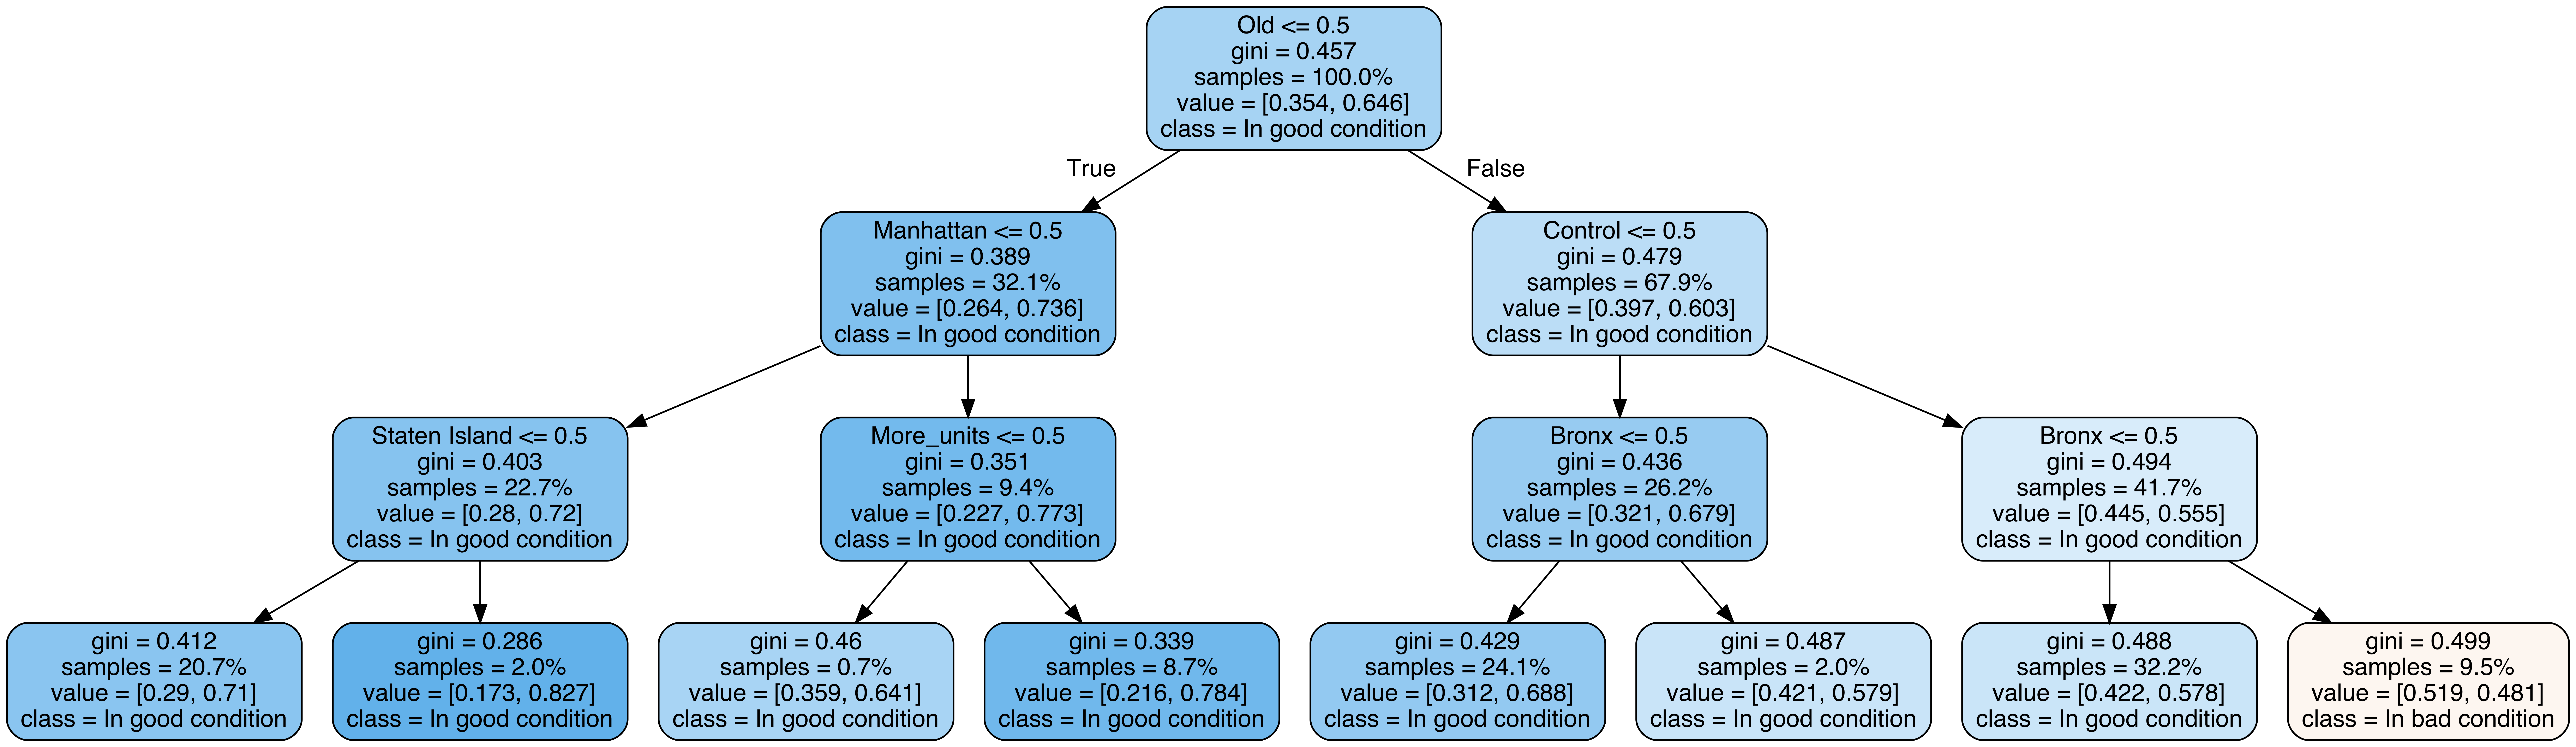

In [82]:
estimator = model.estimators_[0]

forest_gra = export_graphviz(
    estimator,
    out_file='tree.dot',
    feature_names=x_names,
    class_names=y_names,
    rounded=True,
    filled=True,
    proportion=True
)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

### Is rent control significant in the random forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

X_new = data[['Brooklyn','Manhattan', 'Staten Island', 'Bronx', 'Old','More_units']].values
y_new = data['good'].values
#seed = np.random.seed(25)

param_dist1 = {'n_estimators': [10, 200],
               'max_depth': [3, 8], 
               'min_samples_split': sp_randint(2, 20), 
               'min_samples_leaf': sp_randint(2, 20), 
               'max_features': sp_randint(1, 8)}
random_search1 = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist1,
                                    n_iter=100, n_jobs=-1, cv=5,
                                    scoring='neg_mean_squared_error')
forest = random_search1.fit(X_new, y_new)
print('The optimal tuning parameter values are', forest.best_params_)
print('The MSE of the optimal results is', -forest.best_score_)

The optimal tuning parameter values are {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 11, 'min_samples_split': 4, 'n_estimators': 200}
The MSE of the optimal results is 0.35104080364205276
